# RESUMEN DEL NOTEBOOK
(Salvo error u omisión). En este notebook se hace lo siguiente : 
- EN vez de utilizar KERAS, se está utilizando PYTORCH GEOMETRIC. La forma de dfinir la red neuronal es un poco diferente a KERAS. En lo que más se diferencian (creo ) es an la forma de entrenar la red neuronal. En pytorch 'parece' más sencillo.
- Se parte del grafo-dataset 'Zackary's karate club". Dentro del data set ya tiene separado los nodos, las aristas y 4 clases (o grupos de ndos) en las que algien( o algun 'algoritmo de grafos' ) ha clasificado los nodos.
- La red neuronal no conoce las clases asignadas a cada nodo. Solo conoce un nodo por clase . Y el objetivo es que clasifique los nodos en 4 clases. Luego se compara su predicción con la realidad.
- En la primera parte se le aplica una red neuronal estandar y no se obtiene un gran resultado.
- En la segunda parte se le aplica una graph neuronal y el resultado mejora.
- Al principio de cada cada red está el link del blog donde se saca el código.
- Hay código que he generado yo ( el acierto de la predicción) que no está en los blogs pero creo que está bien.
- El apartado de las gráficas (embeddings), creo que es con el siguiente objetivo. Trata de representar en dos dimensiones los nodos con la esperanza de que si todos los del mismo color están muy cerca significa que los está agrupando e identificando muy bien. A partir de un valor 'h' que genera la red neoral, lo pasa por ls función 'z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())', que al parecer la convierte en 2 dimensiones, que son las que pinta en la gráfica. 

https://mattermost.com/blog/graph-neural-networks/

# Graph neural networks using PyTorch Geometric (PyG)
Empezamos a mitad de blog

## Zachary’s karate club


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import gif

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# settings
%matplotlib inline
#plt.style.use("seaborn") # me ha dao un warning "deprecated ..."
gif.options.matplotlib["dpi"] = 300

# Import the karate club
# Also make sure to check out the other datasets available under `torch_geometric.datasets`
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')

# There can be one or more number of graphs in a dataset
# In this case it is only 1.
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

# Node labels are the labels of the community that the node ends up joining
# These labels are obtained by via modularity-based clustering
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


NameError: name 'dataset' is not defined

In [2]:
karate_club = dataset[0]  # Get the dataset graph
print(karate_club)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


Our `karate_club` `Data` object uses four different attributes to represent a graph:

- **Node features**: Denoted by `x`, it contains the feature matrix of the nodes. The size of `x` in this graph is `[34, 34]`, which indicates 34 nodes, each with an attribute of length 34. The attribute for each node is a one-hot vector indicating the node index.
- **Adjacency lists**: Denoted by `edge_index`, it contains the information about the graph’s connectivity.
- **Class labels**: Class labels denote which class each node belongs to.
- **Train mask**: `train_mask` indicates the nodes to which we already know the community they belong. The train set contains one node from each class of the dataset. The dataset has four classes, so the train set contains four points which belong to four different classes. 

In [3]:
# Let us have a look at the connections in the graph.
edge_index = karate_club.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [4]:
# Voy a hacer lo mismo con el resto de los atributos

feature_mat = karate_club.x
print(feature_mat.t())

# Hay 4 'labels [0,1,2,3]
labels = karate_club.y
print(labels.t())

# Hay 4 nodos que ya sabemos algo 'No sé muy bien que' [nodo '0', nodo '4', nodo'8', nodo '24']
train_mask = karate_club.train_mask
print(train_mask.t())

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


In [5]:
print(f'Total number of nodes: {karate_club.num_nodes}')
print(f'Number of training nodes: {karate_club.train_mask.sum()}')
print(f'Training node label rate: {int(karate_club.train_mask.sum()) / karate_club.num_nodes:.2f}')

Total number of nodes: 34
Number of training nodes: 4
Training node label rate: 0.12


### Visualizando el grafo

In [6]:
# Generamos una función que 'wrapper/helper' para los parametros de visualización
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

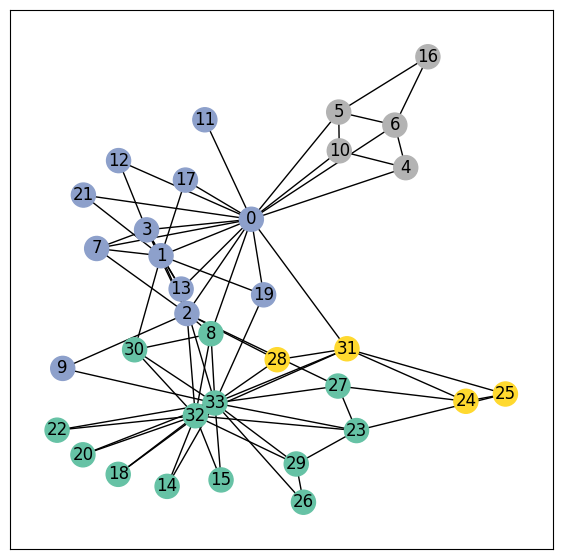

In [7]:
from torch_geometric.utils import to_networkx

# Convert the PyG graph to NetworkX graph
G = to_networkx(karate_club, to_undirected=True)
visualize_graph(G, color=karate_club.y)

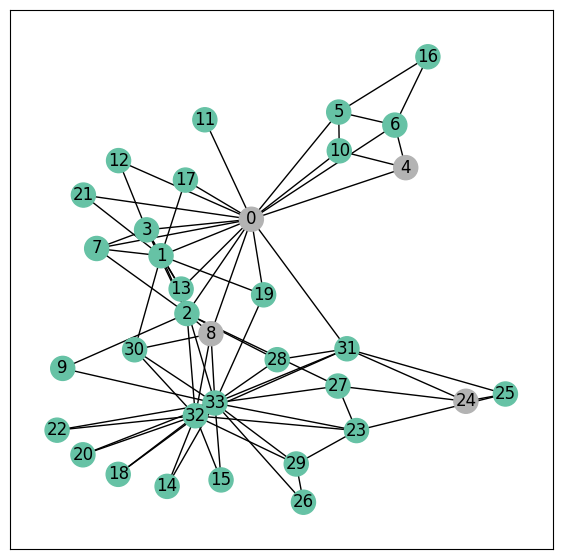

In [8]:
# Voy a intentar visualizar el grafo y que me identifique los 4 nodos especiales
visualize_graph(G, color=karate_club.train_mask)

# Creating the PyTorch Model

## Primera aproximación

Creating your PyTorch models is very easy and come down to two easy steps:

- Initialize building blocks (including flags, variables and layers) in ` __init__` function.
- Define how the computation is performed in the `forward` layer.

The model we’re trying to develop is very basic, so we won’t require any special functions from PyG. Our model is a **two-layered MLP [Multi Layer Perceptron]** with dropout and non-linearities, which accept a graph and apply transformation to the node features.

In [9]:
import torch
from torch.nn import Linear, Dropout, Tanh, ReLU # import the torch layers
torch.manual_seed(140) # for reproducibility


#### Pruebas con <torch.C.Generator>

In [10]:
g_prueba = torch.Generator()
print(g_prueba.get_state())
# print(g_prueba.size())   => AttributeError: 'torch._C.Generator' object has no attribute 'size'
inspect = g_prueba.get_state()
print(type(inspect))
print(inspect.size)
print(len(inspect.tolist()))
print(f"El tensor 'Generator tiene {len(inspect.tolist())} elementos")
print(inspect.tolist())    

tensor([  1, 209, 156,  ...,   0,   0,   0], dtype=torch.uint8)
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7f748c6dc7c0>
5056
El tensor 'Generator tiene 5056 elementos
[1, 209, 156, 241, 48, 61, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 209, 156, 241, 0, 0, 0, 0, 203, 135, 198, 205, 0, 0, 0, 0, 234, 153, 117, 132, 0, 0, 0, 0, 139, 224, 26, 71, 0, 0, 0, 0, 118, 112, 138, 203, 0, 0, 0, 0, 46, 251, 255, 210, 0, 0, 0, 0, 199, 45, 164, 22, 0, 0, 0, 0, 138, 142, 182, 255, 0, 0, 0, 0, 21, 141, 12, 71, 0, 0, 0, 0, 237, 92, 255, 10, 0, 0, 0, 0, 139, 126, 245, 133, 0, 0, 0, 0, 24, 61, 81, 124, 0, 0, 0, 0, 233, 123, 110, 189, 0, 0, 0, 0, 196, 166, 84, 100, 0, 0, 0, 0, 199, 56, 8, 142, 0, 0, 0, 0, 200, 210, 2, 25, 0, 0, 0, 0, 248, 48, 98, 132, 0, 0, 0, 0, 179, 28, 201, 149, 0, 0, 0, 0, 231, 10, 138, 45, 0, 0, 0, 0, 54, 236, 156, 151, 0, 0, 0, 0, 152, 4, 189, 48, 0, 0, 0, 0, 13, 40, 48, 162, 0, 0, 0, 0, 1, 213, 216, 46, 0, 0, 0, 0, 124, 146, 144, 196, 0, 0, 0,

## Seguimos con Primera aproximación

In [11]:
# Define your own model
class MLP(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(MLP, self).__init__()
        self.embed = Linear(in_channels, hidden_channels)
        self.classifier = Linear(hidden_channels, out_channels)
        self.activation = ReLU()
        self.dropout = Dropout(0.5)

    def forward(self, graph):
            x = graph.x            # tomamos el grafo 
            x = self.embed(x)      # fist layer lineal : transforma 'features' en otra dimension
            h = self.activation(x) # non linear function (para aprender mejor)
            h = self.dropout(h)    # para reducir overfitting ( va apagando neuronas al azar)
            x = self.classifier(h) # otra lineal para hacer la clasificación
            return x, h

# Si no me equivoco en nuetro caso las variables han de tomar los siguientes valores
# in_channels = 34
# hidden_channels = 'cuantas neuronas queremos tener'
# out_channels = 4 , tenemos los nodos agrupados en 4 clases, veamos si el modelo las identifica

Let’s initialize the model using the dataset-specific information:


In [12]:
model = MLP(dataset.num_features, 16, dataset.num_classes) # definimos 16 neuronas
print(model)
print(type(model))

MLP(
  (embed): Linear(in_features=34, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=4, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
<class '__main__.MLP'>



### Aquí creo que va a imprimir el primer estado de la red neuronal 

In [13]:
@gif.frame
def visualize_embedding(h, color, epoch=None, loss=None, acc=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.scatter(z[:, 0], z[:, 1], s=140, c=color, cmap="Set2")

    if epoch is not None and loss is not None and acc is not None:
        plt.xlabel(f'Epoch:{epoch}, Loss: {loss.item():.4f}, Acc: {acc.item():.4f}', fontsize=16)

Embedding shape: [34, 16]


<Figure size 800x800 with 0 Axes>

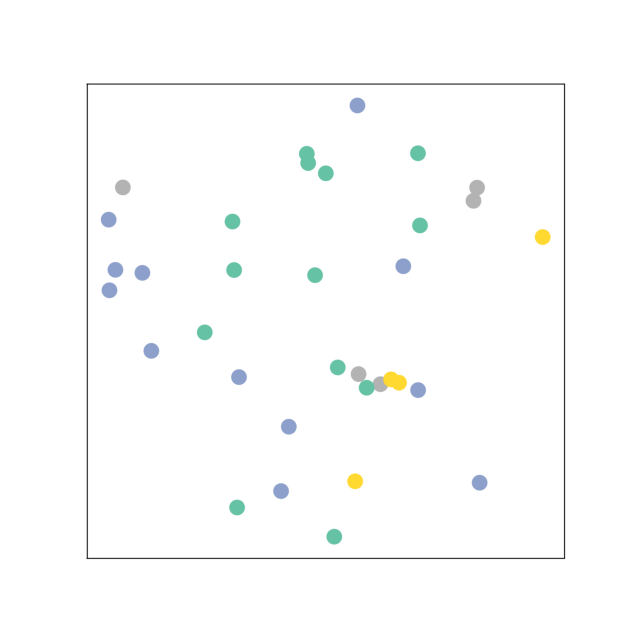

In [14]:
out, h = model(karate_club)
print(f'Embedding shape: {list(h.shape)}')
#print(type(out))
#print(out.size())
#print(out.tolist())
#print(type(h))
#print(h.size())
#print(h.tolist())

plt.figure(figsize = (8,8))
fig = visualize_embedding(h, color=karate_club.y)
plt.figure(figsize = (8, 8))
plt.imshow(fig)
plt.axis('off')
plt.show()

We define an accuracy function to measure the number of correct labels. Our model predicts embedding alongside unnormalized probabilities /logits for the different classes. We use `torch.argmax` to find the class with the maximum probability.

In [15]:
def accuracy(logits, labels):
    # find the accuracy 
    pred = torch.argmax(logits, dim=1)
    acc = torch.mean((pred == labels).float())
    return acc

In [16]:
init_acc = accuracy(out, karate_club.y).item() * 100
print(f"The initial accuracy {init_acc:0.03} %")
another_init_acc = accuracy(out, karate_club.y)
#print(type(another_init_acc))
#print(another_init_acc.dim())
#print(another_init_acc.size())

The initial accuracy 35.3 %


## Entrenamiento del modelo

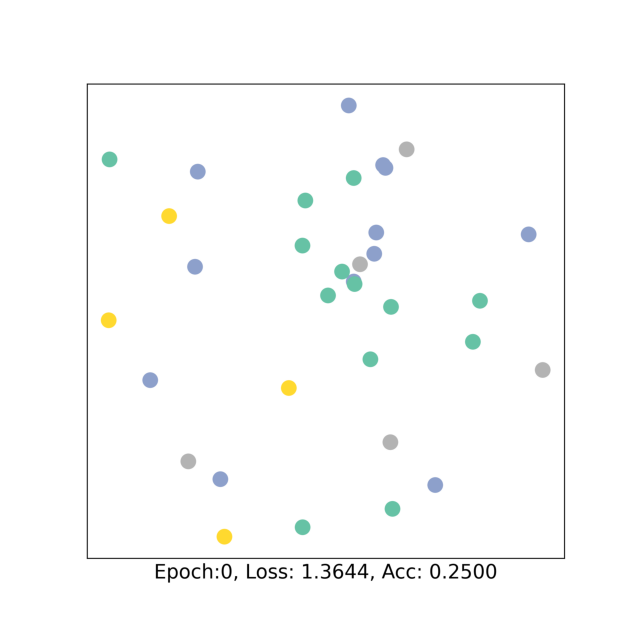

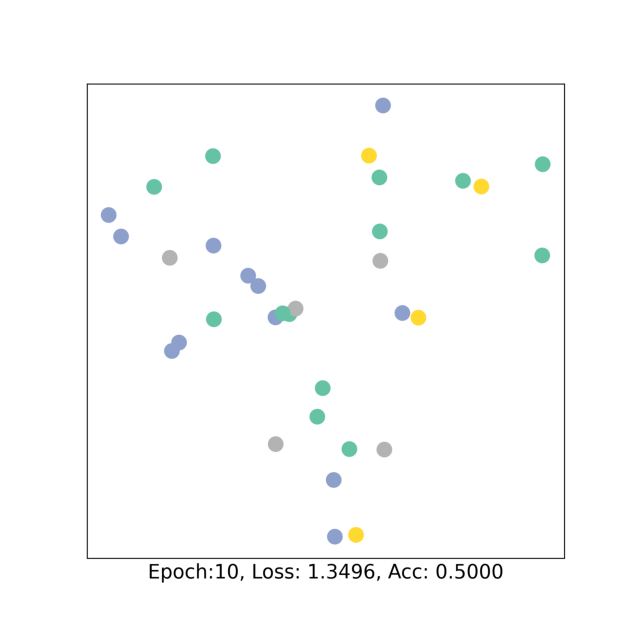

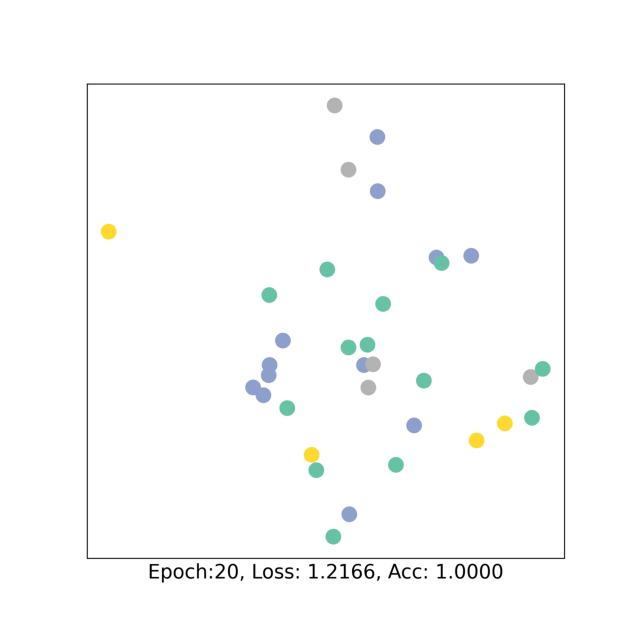

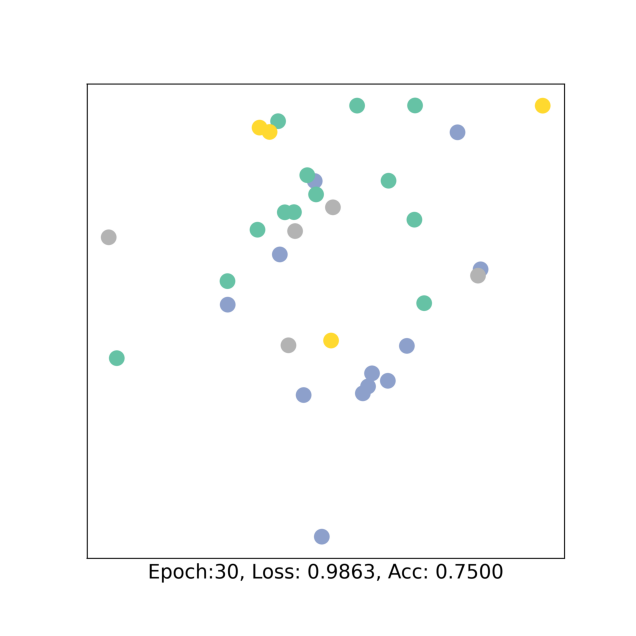

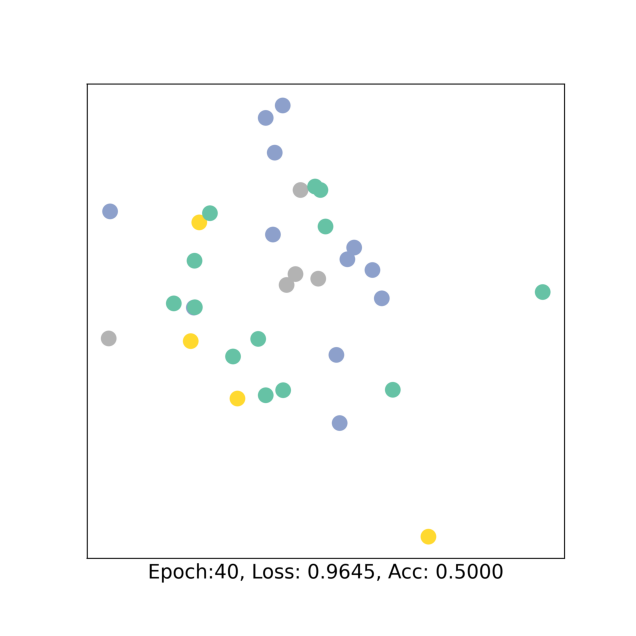

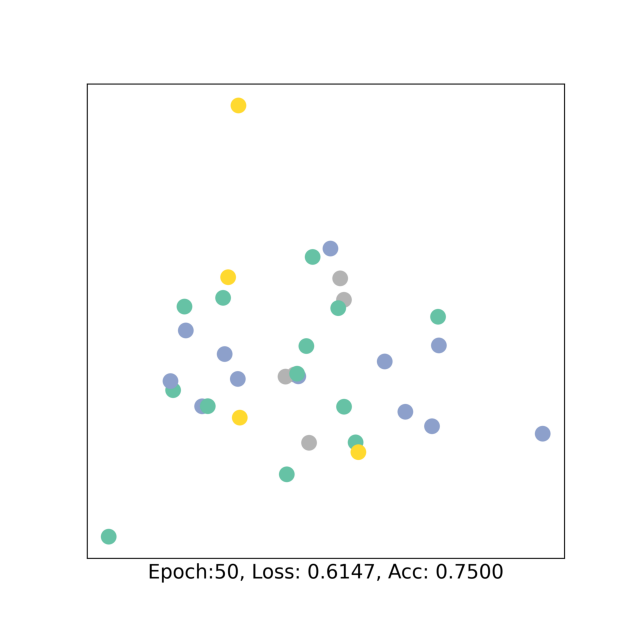

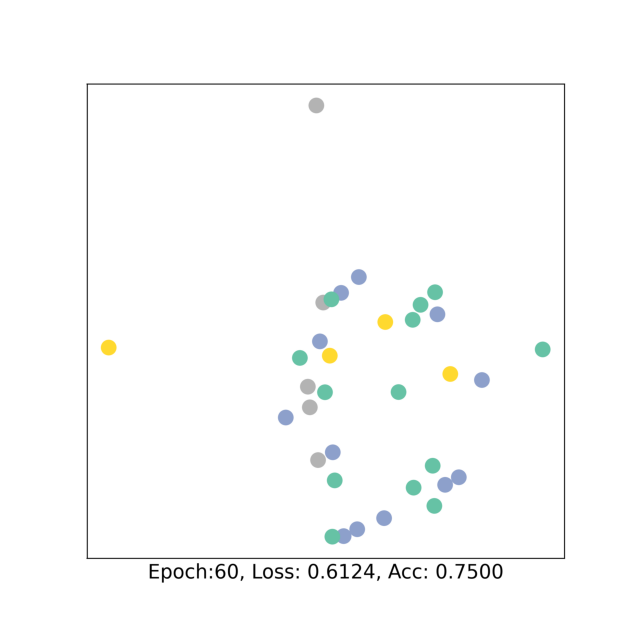

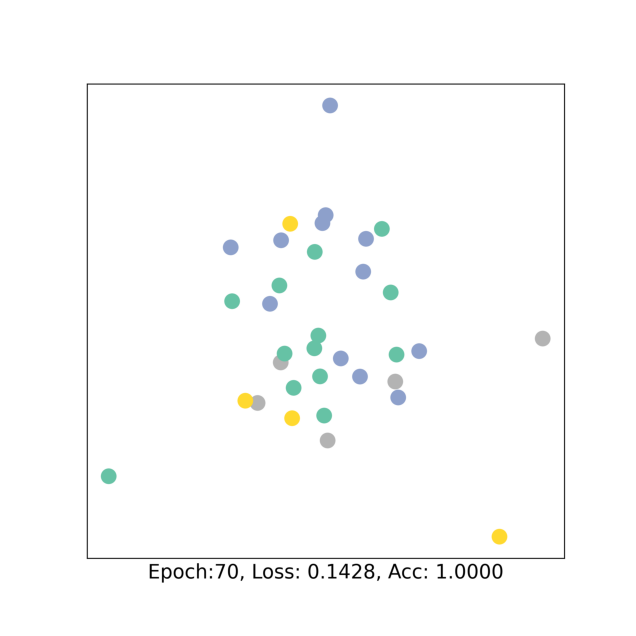

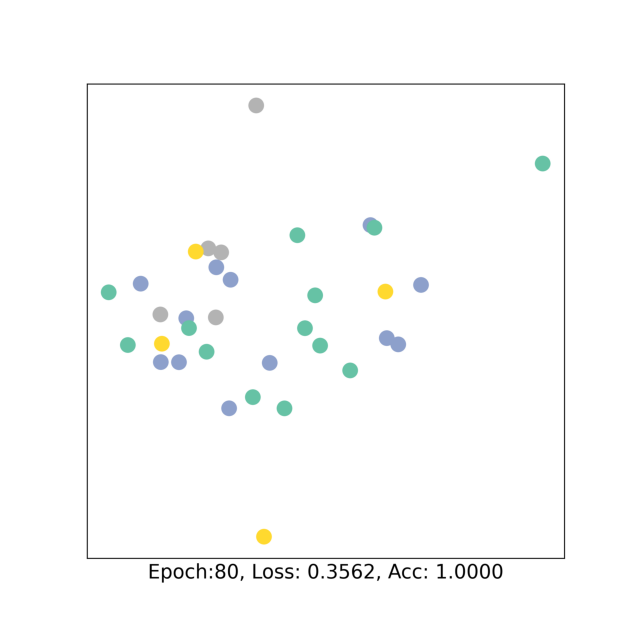

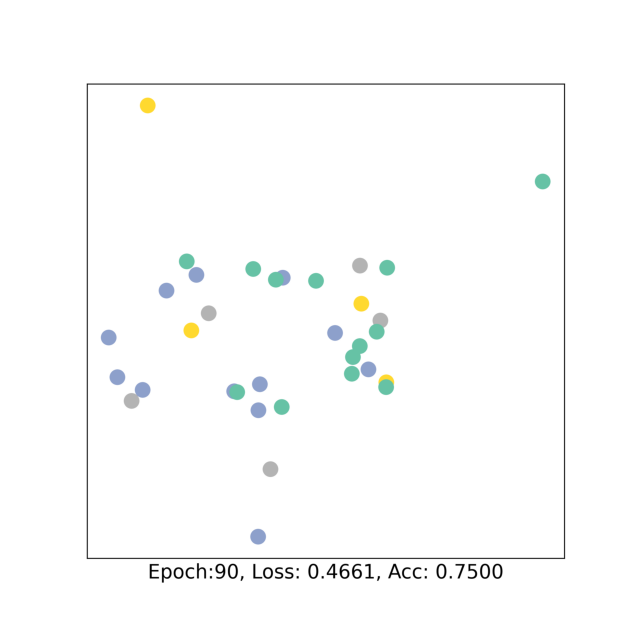

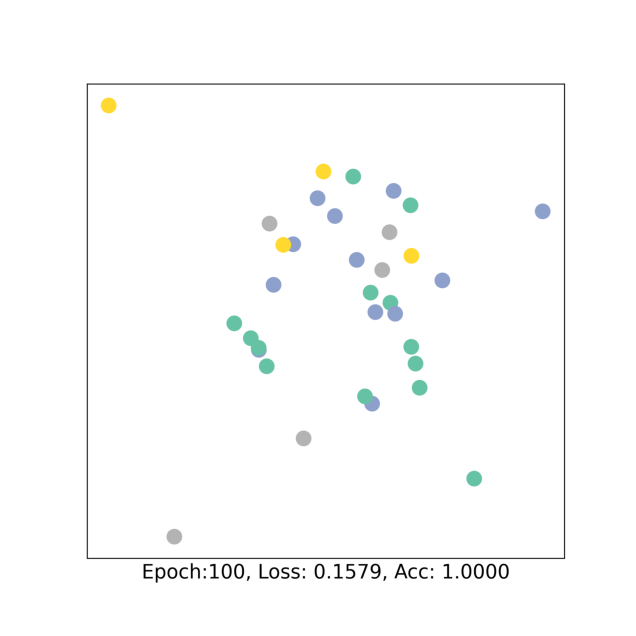

In [20]:
model = MLP(dataset.num_features, 16, 4) # Define our MLP model
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()
    out, h = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    acc = accuracy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h, acc, out # out lo he puesto yo

frames=[]
for epoch in range(110): # creo que en 110 loss era más pequeño
    loss, h, acc, out_mlp = train(karate_club) # out_mlp lo he puesto yo

    if epoch % 10 == 0:
        fig = visualize_embedding(h, color=karate_club.y, epoch=epoch, loss=loss, acc=acc)
        frames.append(fig)
        plt.figure(figsize = (8, 8))
        plt.imshow(fig)
        plt.axis('off')
        plt.show()

Si no estoy equivocado hemos pasado la información de los nodos por una red neuronal de dos capas convencionales.Todavía no hemos utilizado una red 'graph neural network'. Y ahora lo que quiero saber es cuanto ha acertado. Si ha superado el 38,5 % inicial. A ver si ha 'aprendido'algo. Debería, porque ha echo 150 'epochs' y el Loss ha bajado bastante.

In [21]:
pred_mlp = torch.argmax(out_mlp, dim=1)
print(pred_mlp.tolist())
print(labels.tolist())

[1, 1, 2, 0, 1, 3, 0, 2, 0, 0, 2, 1, 0, 1, 1, 0, 3, 1, 2, 3, 0, 3, 3, 0, 2, 3, 1, 2, 2, 0, 0, 2, 2, 3]
[1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0]


In [22]:
acierto_mlp = torch.mean((pred_mlp == labels).float())
print(f"Acierto final MLP : {acierto_mlp.item()}")
# init_acc = accuracy(out, karate_club.y).item() * 100
# print(f"The initial accuracy {init_acc:0.03} %")
acierto_inicial = torch.mean((torch.argmax(out,dim=1) == labels).float())
print(f"Acierto inicial : {acierto_inicial.item()}")

Acierto final MLP : 0.47058823704719543
Acierto inicial : 0.3529411852359772


Si no estoy equivocado ha subido el acierto hata el 47%.

# Implementing Graph Neural Networks
https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=ci-LpZWhRJoI

In [23]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv



# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [24]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [25]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

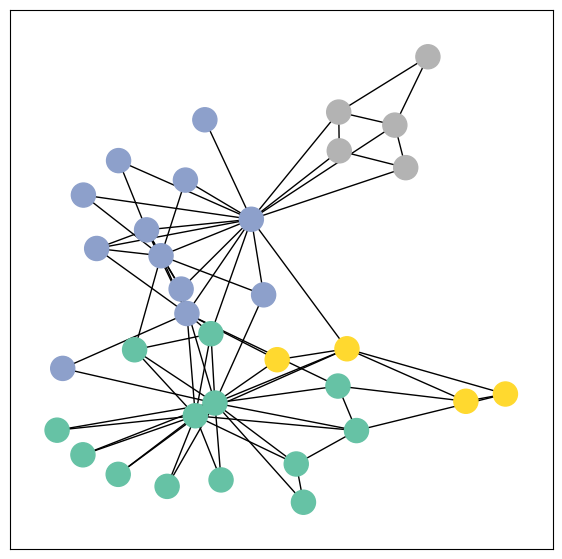

In [26]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [27]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [28]:



class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)
print(type(out))
print(out.size())
print(type(h))
print(h.size())

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
<class 'torch.Tensor'>
torch.Size([34, 4])
<class 'torch.Tensor'>
torch.Size([34, 16])


Embedding shape: [34, 2]


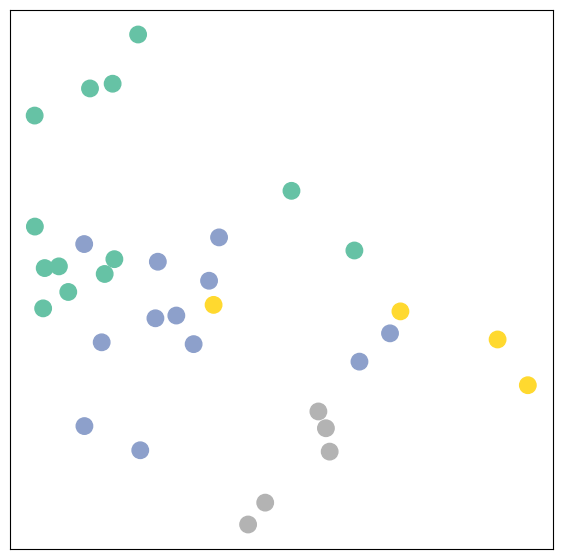

In [29]:
data = dataset[0]
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

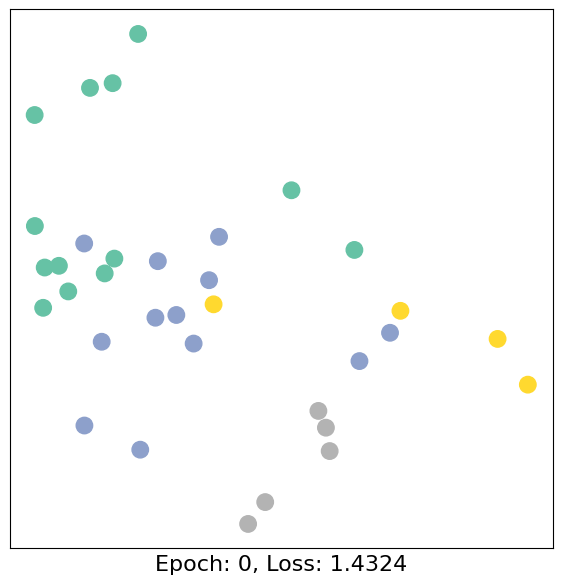

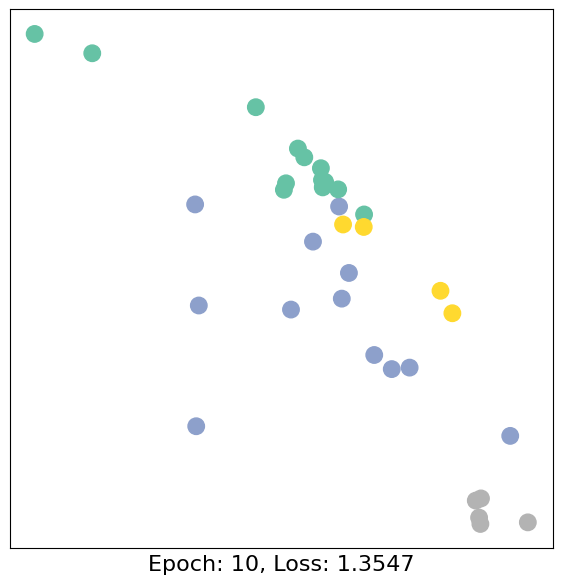

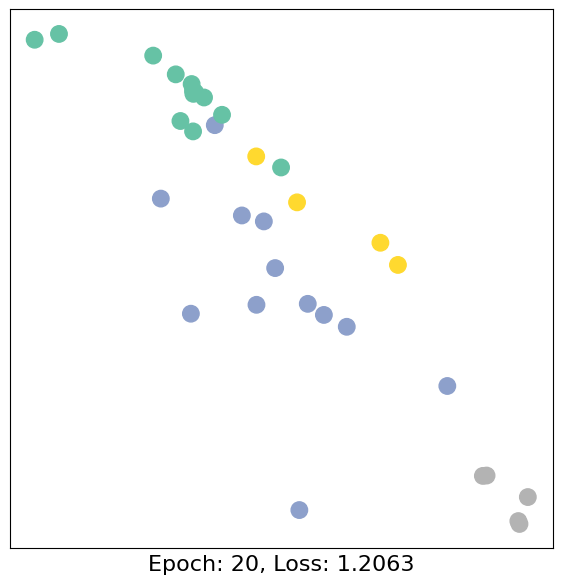

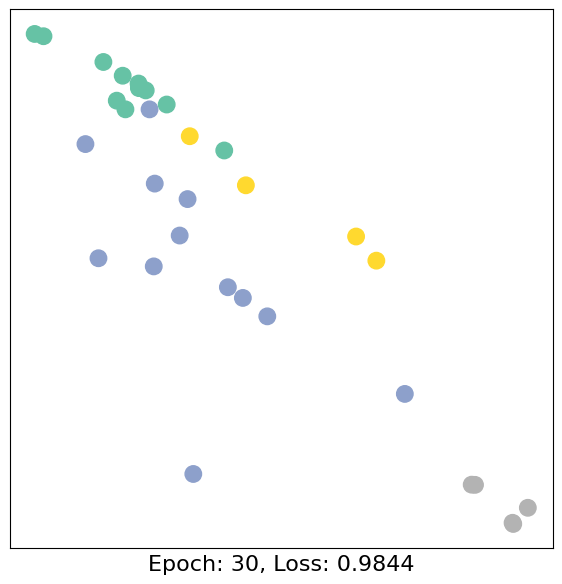

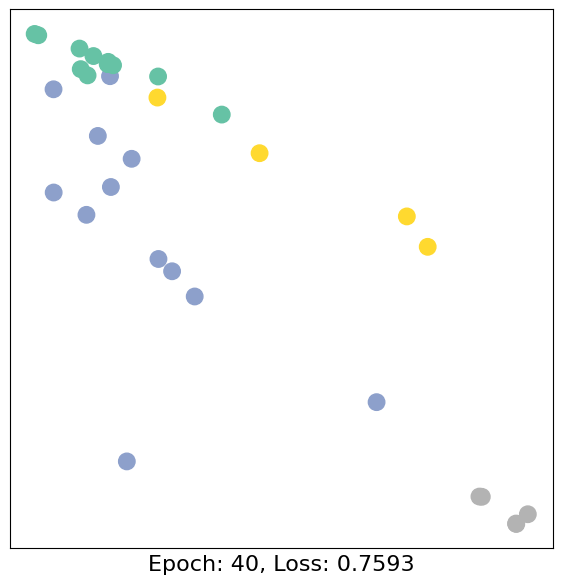

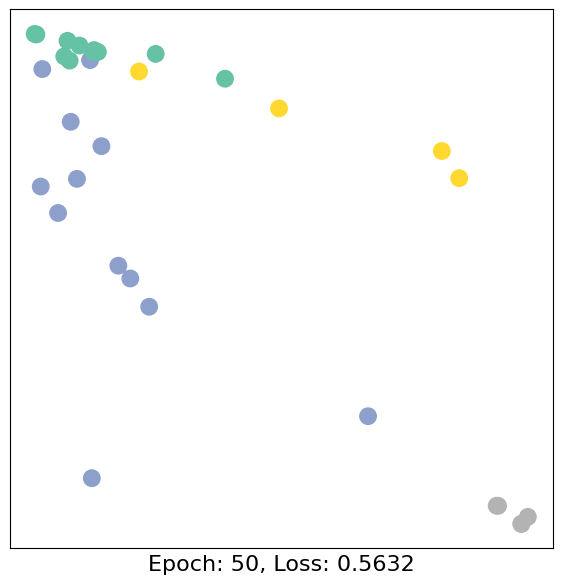

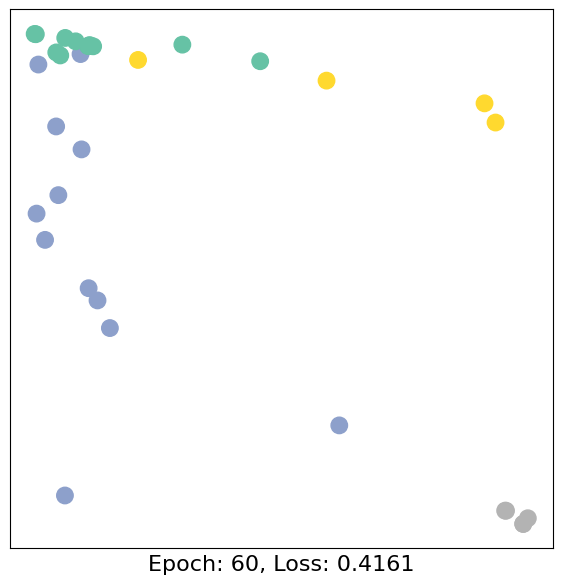

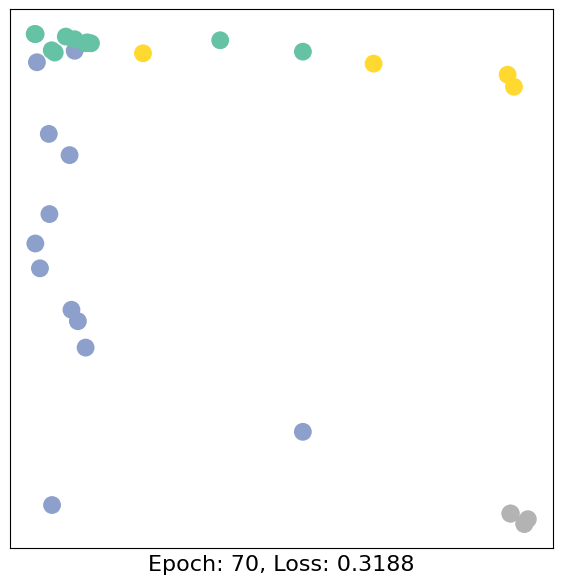

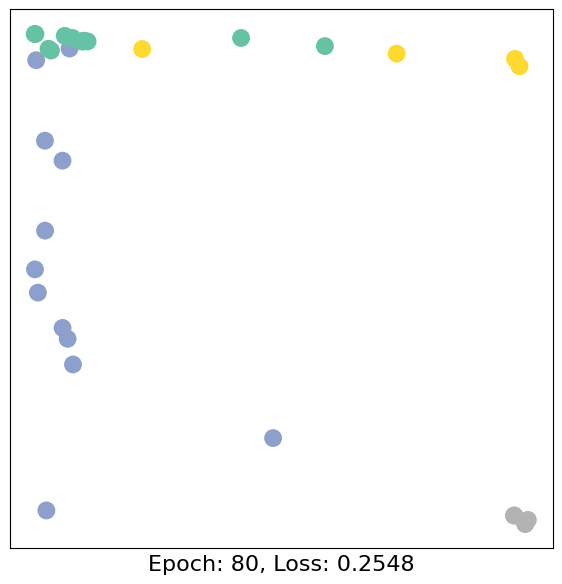

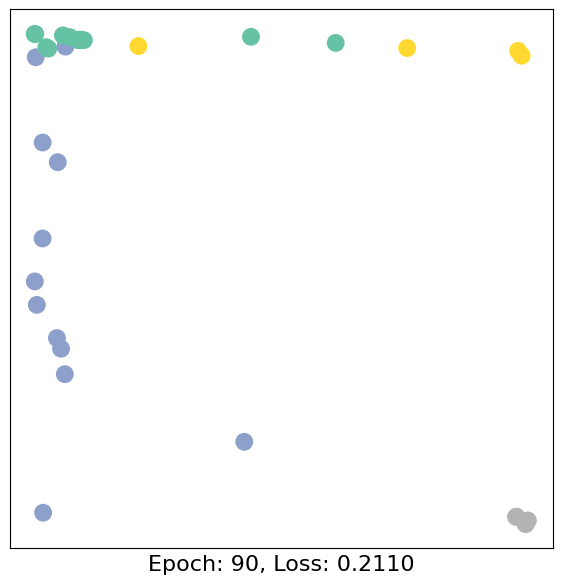

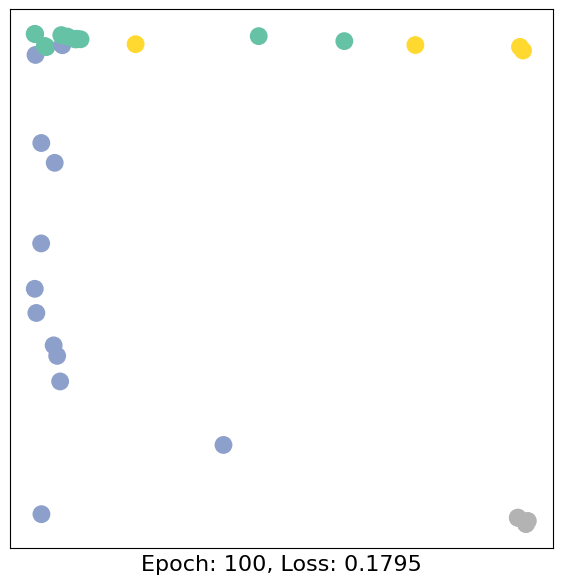

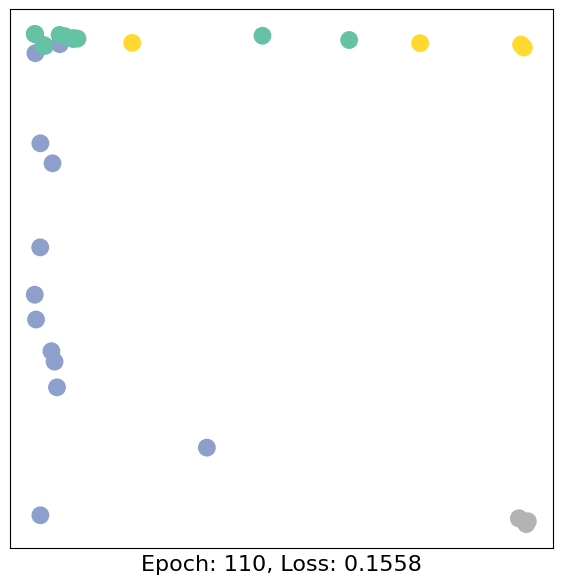

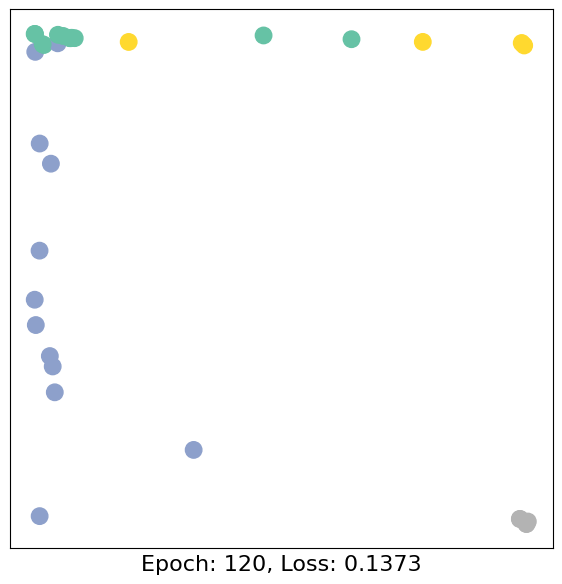

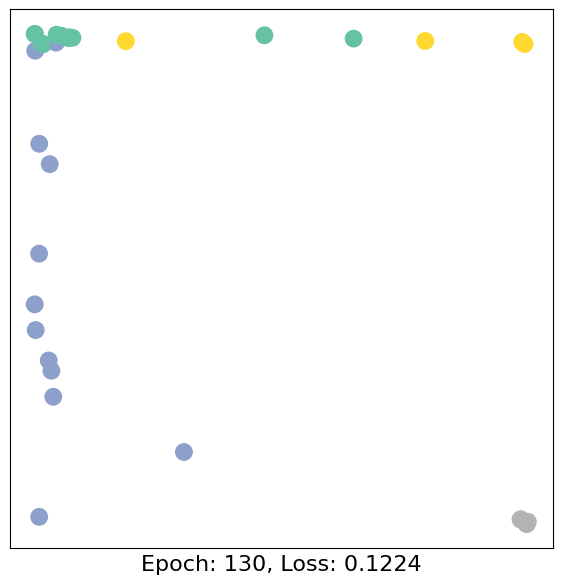

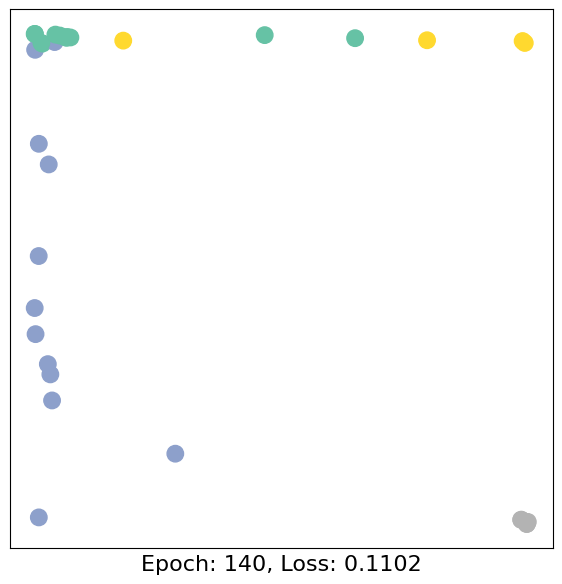

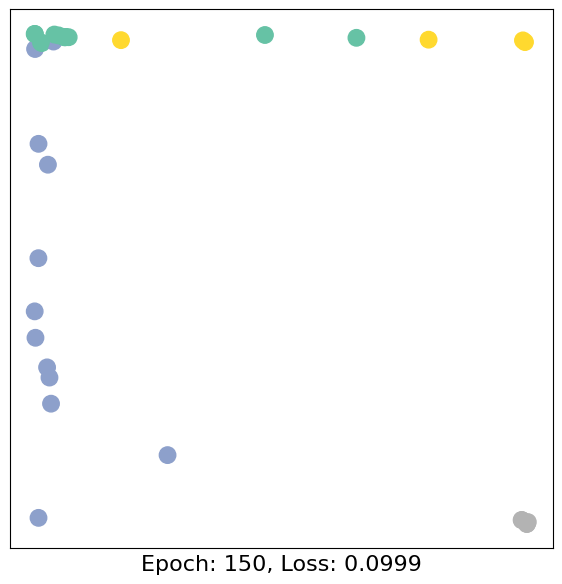

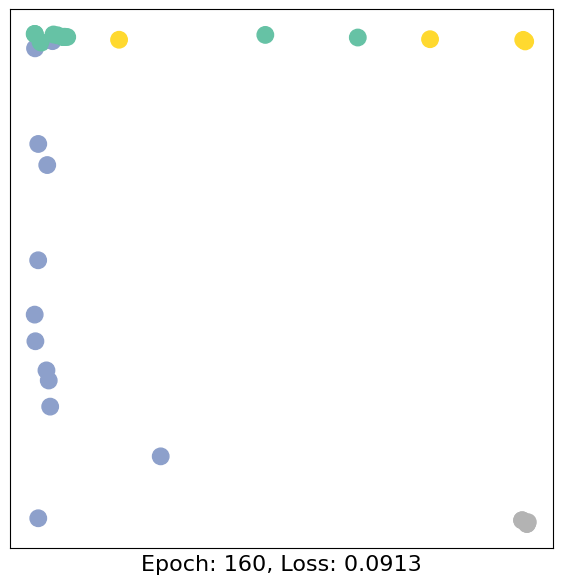

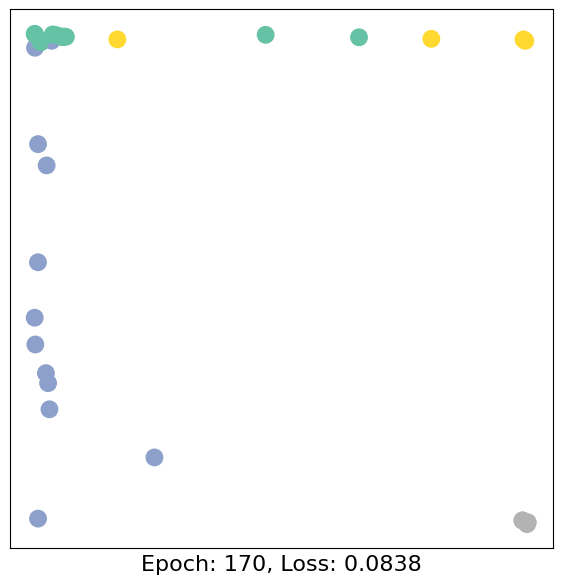

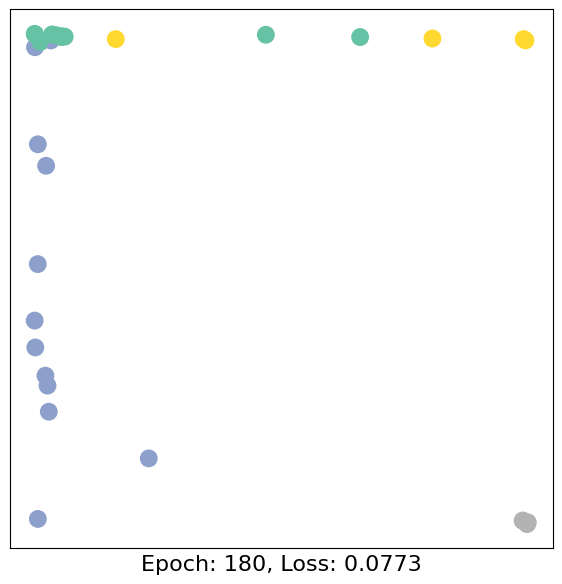

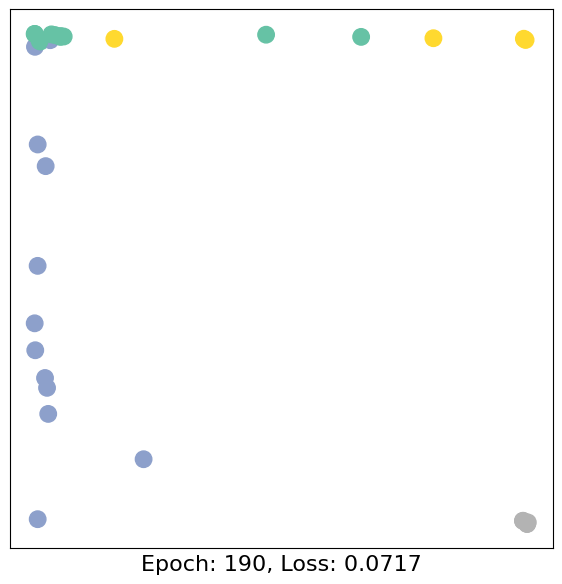

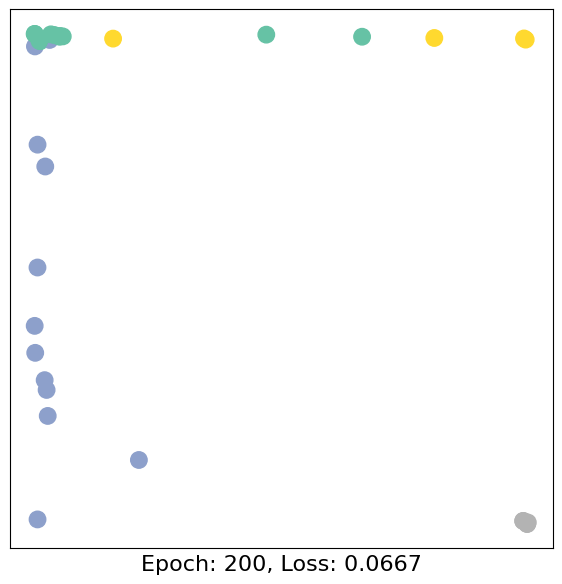

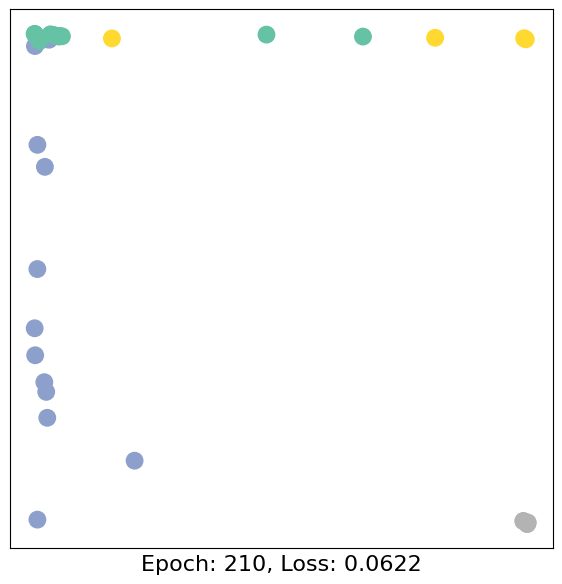

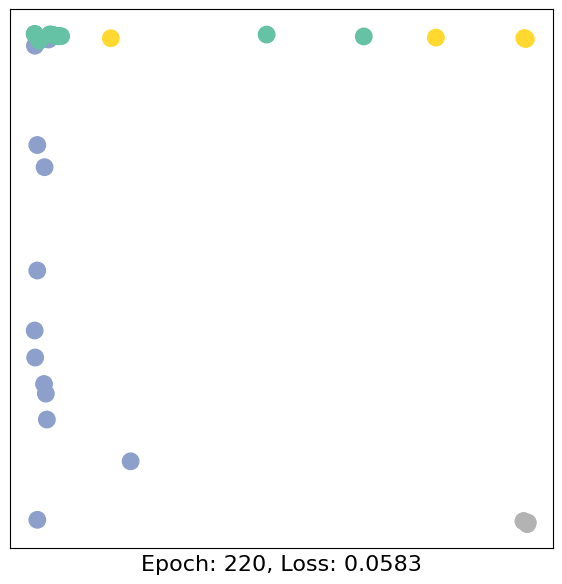

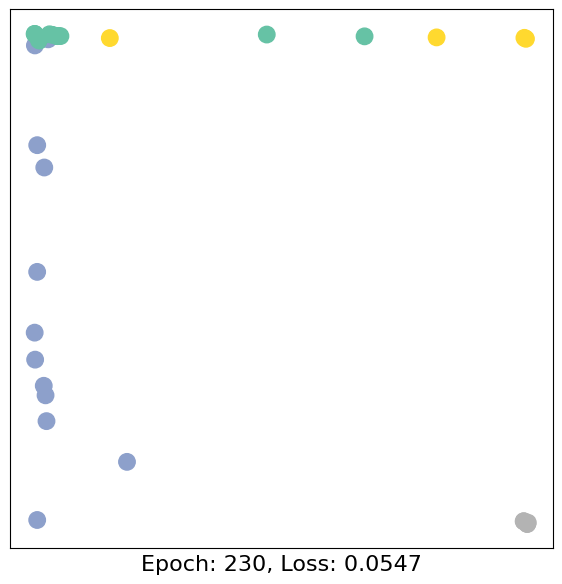

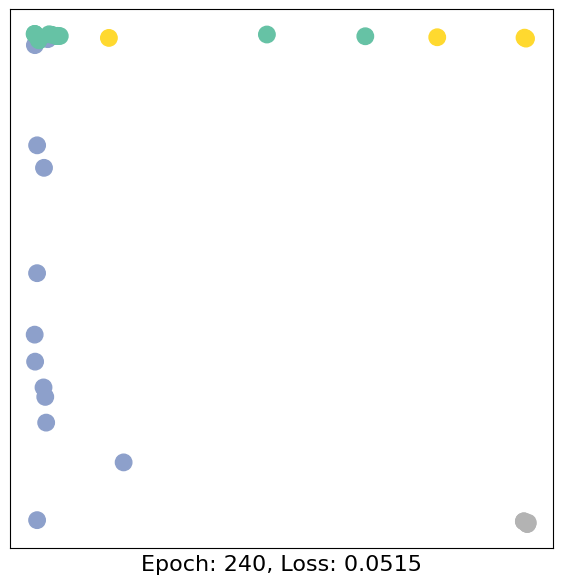

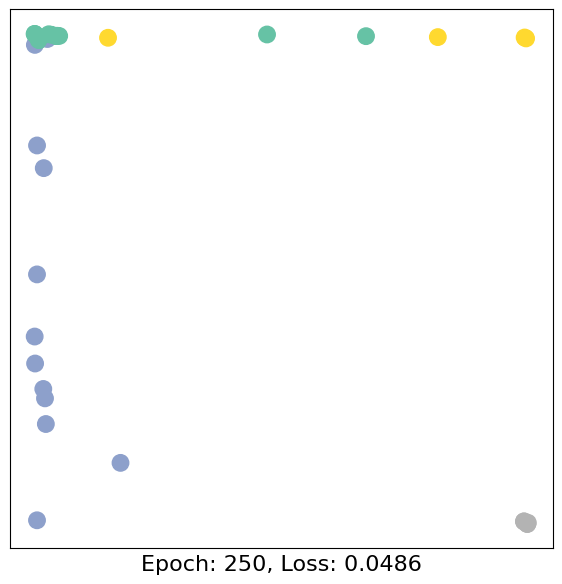

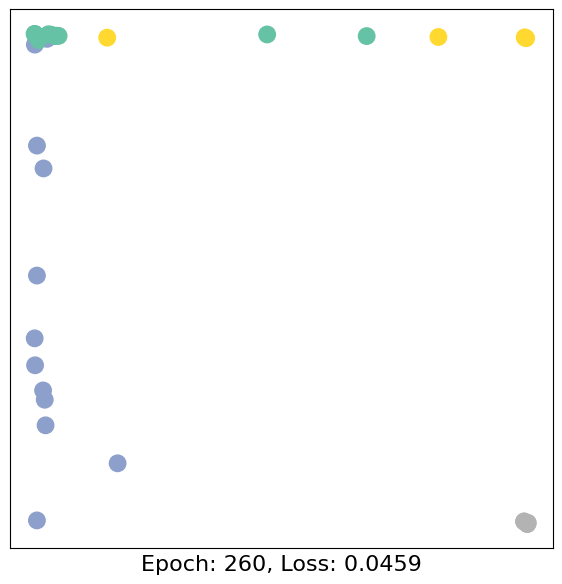

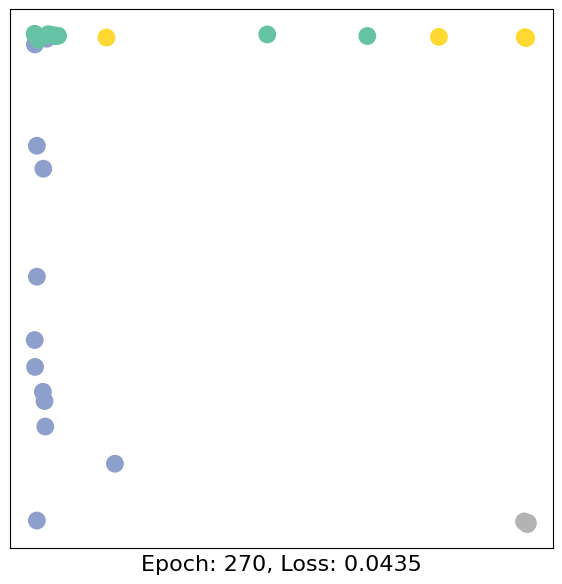

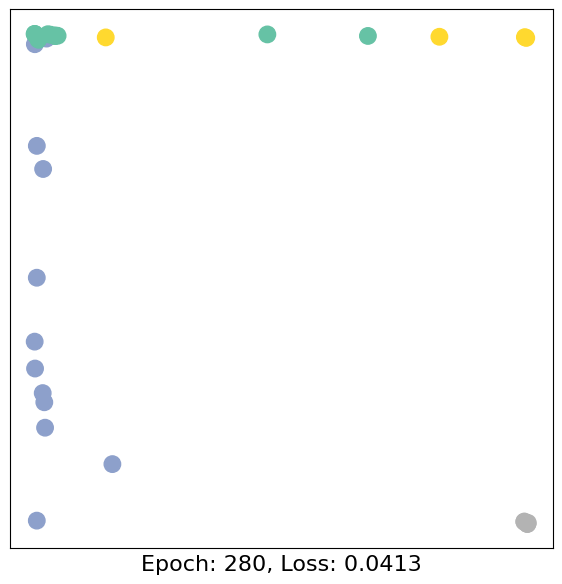

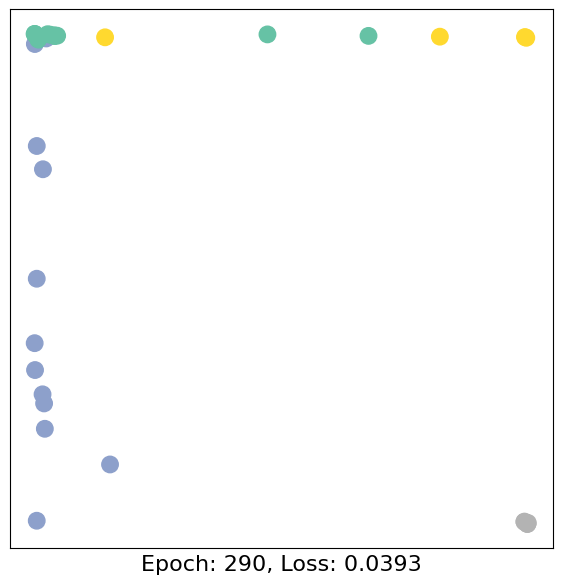

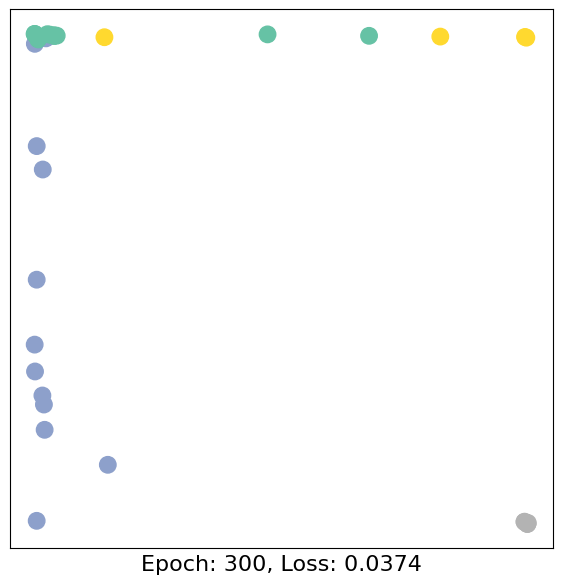

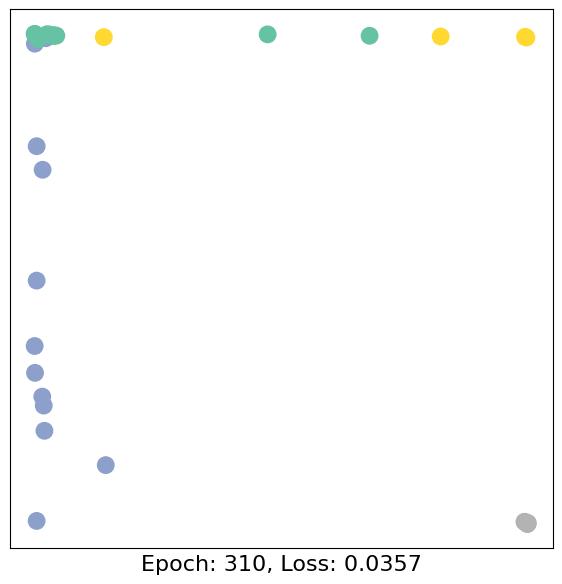

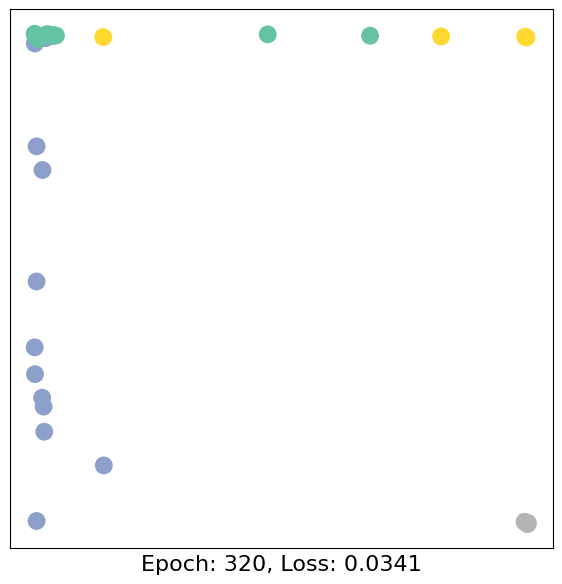

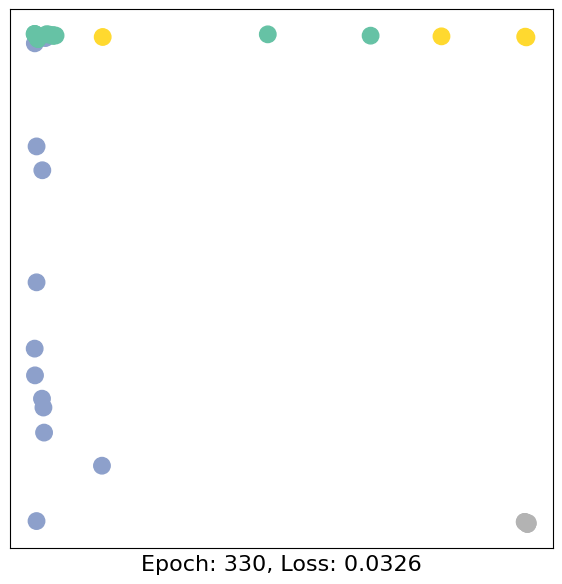

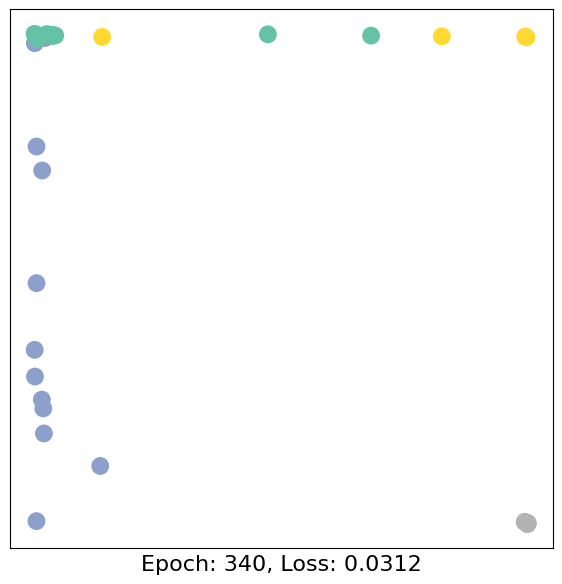

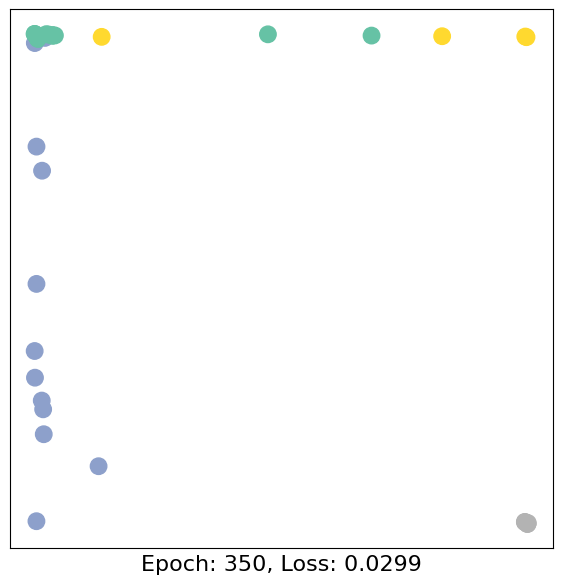

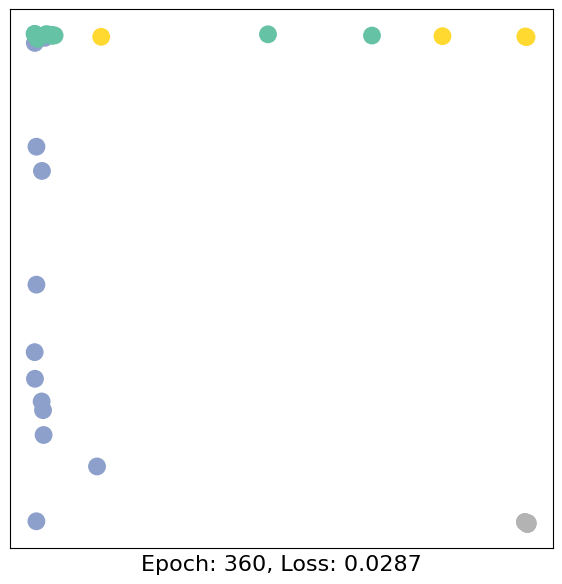

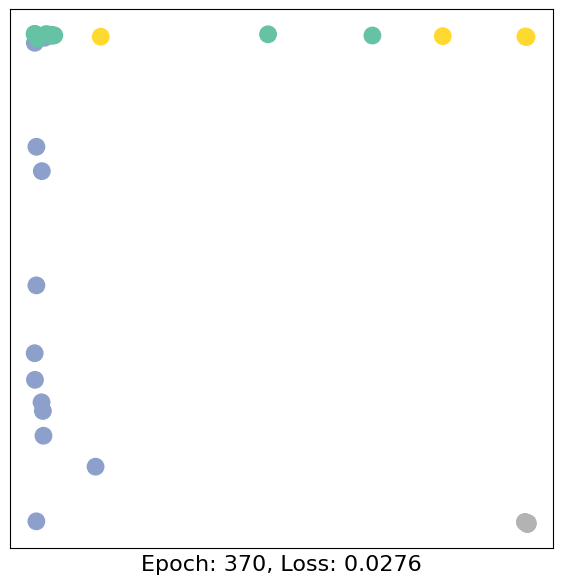

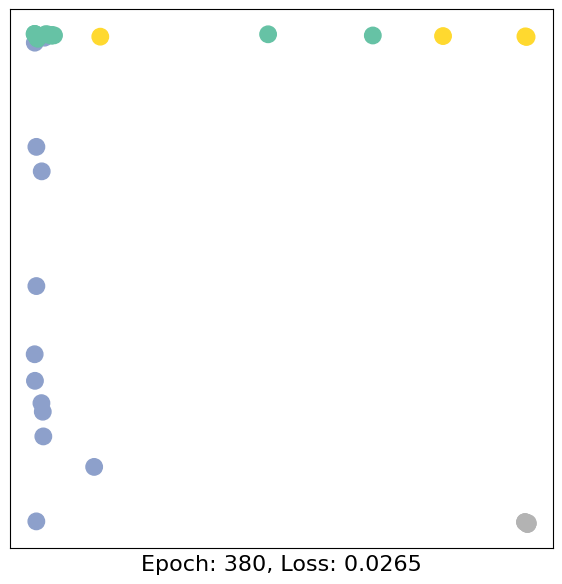

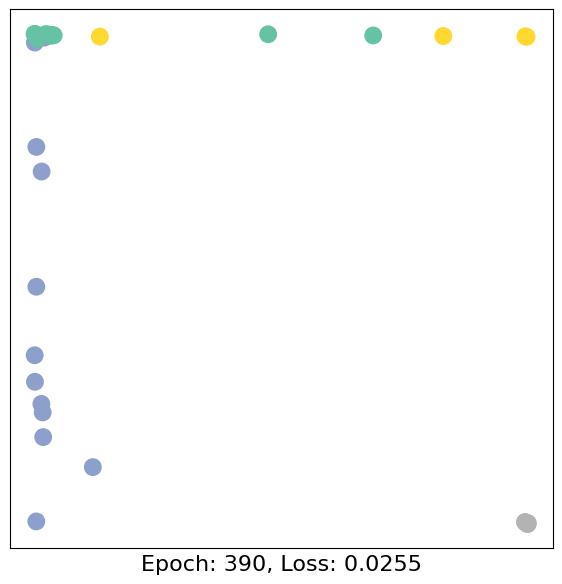

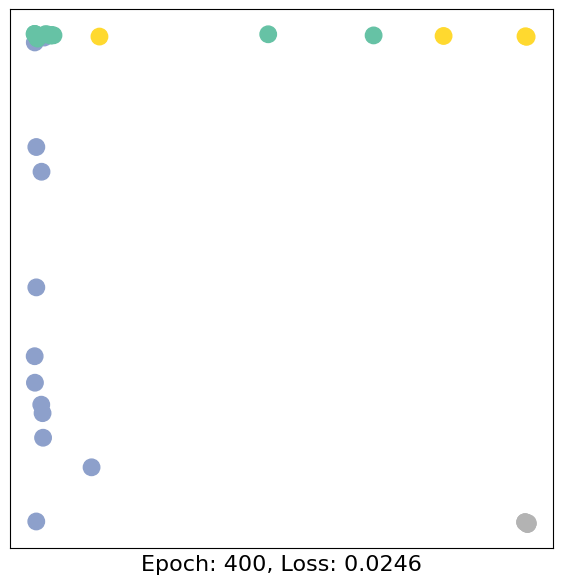

In [30]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out # aquí he escrito out, originalmente no lo recogía

for epoch in range(401):
    loss, h, out_f = train(data) # aquí he escrito out_f, originalmente no lo recogía
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [31]:
print(type(h))

<class 'torch.Tensor'>


In [32]:
print(h.size())

torch.Size([34, 2])


In [33]:
print(h.tolist())

[[-0.9934132099151611, -0.9871662259101868], [-0.9999170303344727, -0.3135608434677124], [-0.9993868470191956, 0.9653265476226807], [-0.9988330006599426, -0.4215511679649353], [0.987281858921051, -0.9899470806121826], [0.996787965297699, -0.9972116947174072], [0.9968003034591675, -0.9971958994865417], [-0.9932385087013245, -0.032987840473651886], [-0.9872255325317383, 0.9820225834846497], [-0.9614216089248657, 0.9853107929229736], [0.9874438047409058, -0.9899429082870483], [-0.7694101333618164, -0.7663608193397522], [-0.9658485651016235, -0.6457991600036621], [-0.9931972622871399, 0.5390956997871399], [-0.9344760179519653, 0.9943640828132629], [-0.9331079125404358, 0.9944119453430176], [0.9982737302780151, -0.9938291311264038], [-0.9679274559020996, -0.5456528663635254], [-0.9308827519416809, 0.9949498772621155], [-0.9721497893333435, 0.4383663535118103], [-0.923672080039978, 0.9944605827331543], [-0.9732134938240051, -0.511111855506897], [-0.9315316081047058, 0.9943849444389343], [-0.

In [34]:
acc2 = accuracy(out[data.train_mask], data.y[data.train_mask])
acc_f = accuracy(out_f[data.train_mask], data.y[data.train_mask])

In [35]:
print(acc2.item())
print(acc_f.item())

0.25
1.0


In [36]:
print(out[data.train_mask].tolist())
print(out_f[data.train_mask].tolist())

[[-0.05676531046628952, 0.1630476713180542, -0.15649282932281494, -0.09553712606430054], [-0.07834917306900024, 0.1896291822195053, -0.14024591445922852, -0.1300138235092163], [-0.18097926676273346, 0.27559053897857666, -0.06014486402273178, -0.043453872203826904], [-0.134292334318161, 0.14785706996917725, -0.2795230746269226, -0.10851563513278961]]
[[-0.2347586452960968, 4.355334758758545, -4.4269890785217285, 0.14366364479064941], [-3.9136147499084473, 0.8398287892341614, 0.6013264656066895, 5.059818744659424], [4.337045192718506, -0.21352308988571167, -0.014117985963821411, -4.34235954284668], [0.6793097257614136, -3.749572277069092, 5.033911228179932, 0.5529694557189941]]


In [37]:
print(data.y[data.train_mask].tolist())

[1, 3, 0, 2]


In [38]:
pred2= torch.argmax(out[data.train_mask], dim=1)
print(pred2.tolist())
pred_f= torch.argmax(out_f[data.train_mask], dim=1)
print(pred_f.tolist())

[1, 1, 1, 1]
[1, 3, 0, 2]


Voy a mirar el resto de las predicciones

In [39]:
pred_total = torch.argmax(out_f, dim=1)
print(pred_total.tolist())
print(labels.tolist())

[1, 1, 0, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0]
[1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0]


In [40]:
acierto_final = torch.mean((pred_total == labels).float())
print(f"Acierto final : {acierto_final.item()}")
# init_acc = accuracy(out, karate_club.y).item() * 100
# print(f"The initial accuracy {init_acc:0.03} %")
acierto_inicial = torch.mean((torch.argmax(out,dim=1) == labels).float())
print(f"Acierto inicial : {acierto_inicial.item()}")

Acierto final : 0.8235294222831726
Acierto inicial : 0.3529411852359772


Utilizando una Graph Neural Networt (GCN de pytorch) compuesta de tres GCNConv ha mejorado la prediccion hasta un 82%.